# Step 0.1. Import necessary libraries 

In [1]:
# Standard python libraries
import logging
import os
import time

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from tqdm.notebook import tqdm

from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole

In [2]:
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB

from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToNumpySeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

In [3]:
X_train = pd.read_csv('./ts_dataset_1id.csv')
X_train['date'] = pd.to_datetime(X_train.date)

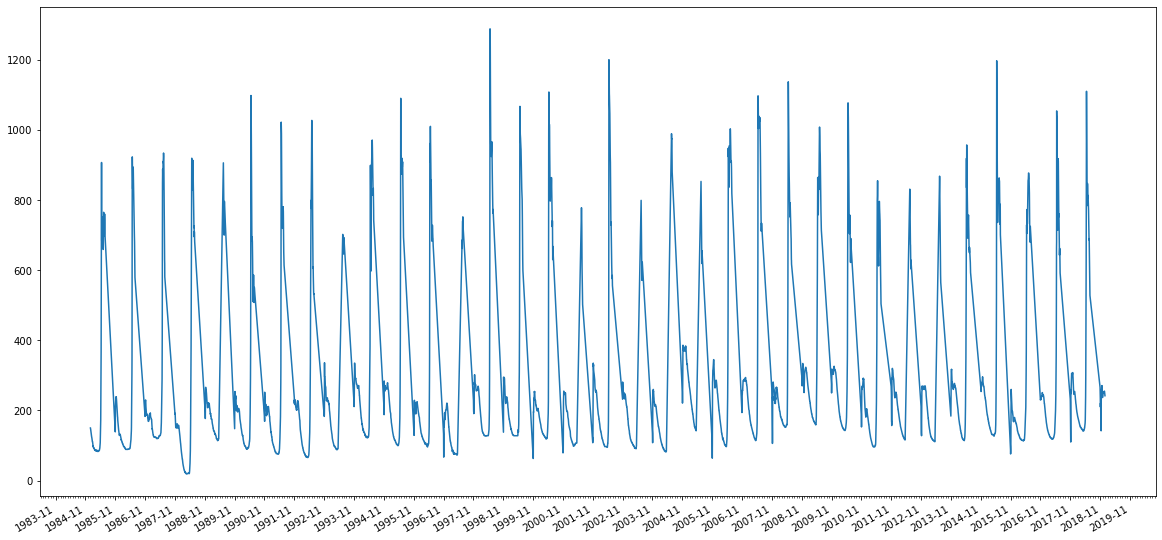

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('date', 'stage_max', data=X_train)
fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')

fig.autofmt_xdate()
plt.show()

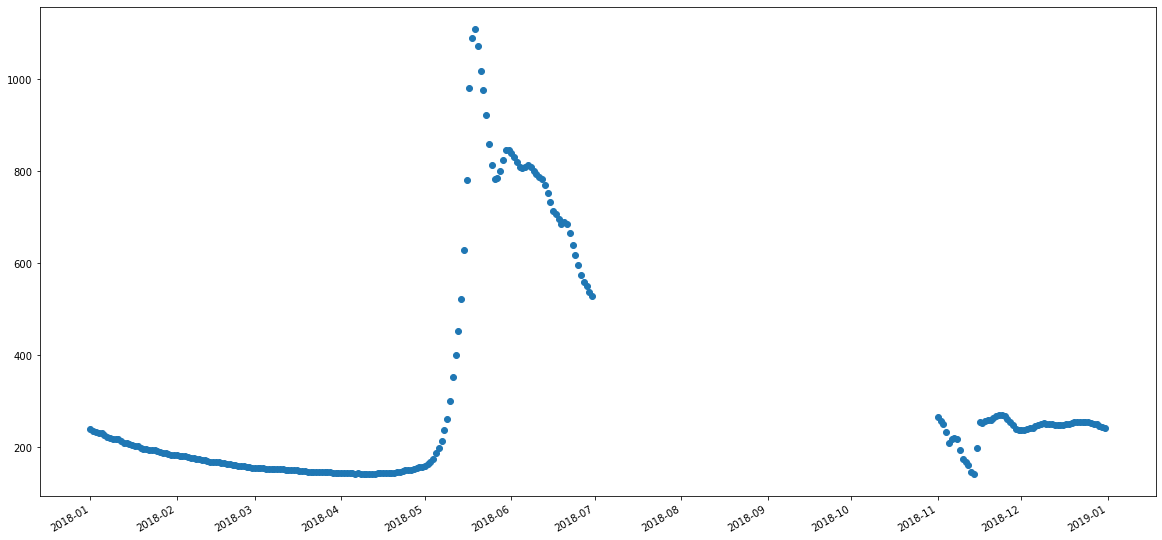

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('date', 'stage_max', data=X_train[X_train.date >= '2018-01-01'], linestyle='none', marker='o')
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')

fig.autofmt_xdate()
plt.show()

In [6]:
# Логика работы c пропусками:
# На текущий момент реализована только одна стратегия:
# На обучении: выбрасываются все наблюдения, для которых невозможно собрать полный набор таргетов и признаков
# На тестировании: выбрасываются все наблюдения, для которых невозможно собрать полный набор признаков.

In [7]:
col = X_train[X_train.date >= '2018-01-01'].date

In [8]:
X_train['station_id'] = 1

In [9]:
# трейн датасет
train = X_train.iloc[:-len(col)].copy().fillna(0)
# тест датасет
# +7 точек пересечения с трейном для подсчета признаков на первую дату теста
test = X_train.iloc[-(len(col)+7):].copy().fillna(0)

In [10]:
seq_params = {'seq0': {'case': 'next_values', # тип задачи, которую решаем - предсказание следующих значений ряда
                           'params': {'n_target': 7, # число точек, на сколько вперед предсказываем
                                      'history': 7, # размер истории для подсчета признаков
                                      'step': 1, # шаг, через сколько точек взять следующие наблюдение
                                      'from_last': True, # датасет заканчивается на последнем доступном наблюдении 
                                      'test_last': False # предсказывать только последний участок из теста
                                     }},}

roles = {'target': 'stage_max',
         DatetimeRole(seasonality=('d', 'm', 'doy'), base_date=True): 'date',
        'id': ['station_id']}
task = Task('multi:reg', greater_is_better=False, metric='mae', loss='mae')

reader_seq = DictToNumpySeqReader(task=task, cv=2, seq_params=seq_params)
feats_seq = LGBSeqSimpleFeatures(scaler=True, fill_na=True)
model = RandomForestSklearn(default_params={'verbose': 0})
model2 = LinearLBFGS()
model3 = BoostCB()
pipeline_lvl1 = MLPipeline([model], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
pipeline2_lvl1 = MLPipeline([model2], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
pipeline3_lvl1 = MLPipeline([model3], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
automl_seq = AutoML(reader_seq,
                         [[pipeline_lvl1,
                           pipeline2_lvl1,
                           pipeline3_lvl1
                          ]],
                         skip_conn=False,
                         blender=WeightedBlender())

oof_pred_seq = automl_seq.fit_predict({'seq': {'seq0': train}}, roles=roles, verbose=4)
seq_test = automl_seq.predict({'seq': {'seq0': test}})

multi:reg isn`t supported in lgb
[12:31:43] Layer 1 train process start. Time left 9999999999.62 secs
[12:31:45] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[12:31:45] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'mse'}
[12:31:45] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[12:32:23] Score for RF model: -12.168469
[12:32:23] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[12:33:02] Score for RF model: -12.617063
[12:33:02] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -12.392733826047476
[12:33:02] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[12:33:02] T

[12:34:23] bestTest = 90.46230883
[12:34:23] bestIteration = 2999
[12:34:23] ===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_0_CatBoost =====
[12:34:23] 0:	learn: 617.6368792	test: 640.3698262	best: 640.3698262 (0)	total: 25.5ms	remaining: 1m 16s
[12:34:25] 100:	learn: 115.0848147	test: 138.9370323	best: 138.9370323 (100)	total: 1.95s	remaining: 56s
[12:34:27] 200:	learn: 84.3215485	test: 121.5032139	best: 121.5032139 (200)	total: 3.8s	remaining: 52.9s
[12:34:29] 300:	learn: 68.7086339	test: 116.7438148	best: 116.7438148 (300)	total: 5.66s	remaining: 50.8s
[12:34:31] 400:	learn: 57.7733289	test: 114.2465410	best: 114.2465410 (400)	total: 7.55s	remaining: 49s
[12:34:33] 500:	learn: 49.8459822	test: 112.5834815	best: 112.5834815 (500)	total: 9.4s	remaining: 46.9s
[12:34:34] 600:	learn: 43.5326362	test: 111.3225831	best: 111.3225831 (600)	total: 11.2s	remaining: 44.8s
[12:34:36] 700:	learn: 38.6163119	test: 110.5507738	best: 110.5249974 (697)	total: 13s	remaining: 42.8s
[12:34:38] 80

In [ ]:
[02:36:46] Score for RF model: -12.146274
[02:36:46] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[02:37:16] Score for RF model: -12.611733
    
[02:39:34] bestTest = 106.8945119

[02:37:21] Linear model: C = 100000 score = -23.041141291382424


In [10]:
# Альтернативный способ запуска:
model = AutoTS(task, seq_params=seq_params, trend_params={'trend': False})
oof_pred_seq = model.fit_predict(train, roles=roles, verbose=4)
seq_test = model.predict(test, return_raw=True)

[02:39:35] Layer 1 train process start. Time left 9999999999.73 secs
[02:39:36] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[02:39:36] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'mse'}
[02:39:36] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[02:40:06] Score for RF model: -12.146274
[02:40:06] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[02:40:36] Score for RF model: -12.611733
[02:40:36] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -12.378969737972705
[02:40:36] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[02:40:36] Time left 9999999939.21 secs

[02:

[02:41:49] bestIteration = 2999
[02:41:50] ===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_0_CatBoost =====
[02:41:50] 0:	learn: 617.6368792	test: 640.3698262	best: 640.3698262 (0)	total: 23.8ms	remaining: 1m 11s
[02:41:52] 100:	learn: 115.0848147	test: 138.9368405	best: 138.9368405 (100)	total: 2.16s	remaining: 1m 2s
[02:41:54] 200:	learn: 84.3215485	test: 121.5031076	best: 121.5031076 (200)	total: 4.17s	remaining: 58.1s
[02:41:56] 300:	learn: 68.7086339	test: 116.7450040	best: 116.7450040 (300)	total: 6.12s	remaining: 54.9s
[02:41:58] 400:	learn: 57.7733289	test: 114.2477147	best: 114.2477147 (400)	total: 8.04s	remaining: 52.1s
[02:42:00] 500:	learn: 49.8459822	test: 112.5854561	best: 112.5854561 (500)	total: 10s	remaining: 49.9s
[02:42:02] 600:	learn: 43.5326362	test: 111.3245472	best: 111.3245472 (600)	total: 12s	remaining: 47.9s
[02:42:04] 700:	learn: 38.6163119	test: 110.5525433	best: 110.5267669 (697)	total: 14s	remaining: 45.8s
[02:42:06] 800:	learn: 34.6219781	test: 109.9

In [11]:
# структура предсказаний
# pred:
# pred[0] - предсказание на первых history теста,
# в нашем случае - с признаков последней недели трейна на первую неделю теста
# pred[-1] - предсказание последних history теста,
# в нашем случае это признаки последних 7 дней тестовых данных на неизветное для нас будущее.

# Так же можно посмотреть базовую дату, от которой делалось предсказание:
# seq_test.date
# Тогда структура выглядит следующим образом:
# БД: БД + 1, БД + 2, ... БД + 7.
# pred[i] = [day1, day2, ..., day7]

seq_test.date[0], seq_test.date[-1]

(numpy.datetime64('2017-12-31T00:00:00.000000000'),
 numpy.datetime64('2018-12-31T00:00:00.000000000'))

Day 1: RMSE 22.548188636458473: MAE 9.27916740255153
Day 2: RMSE 31.294454963237932: MAE 13.484963216495105
Day 3: RMSE 36.96926503063696: MAE 16.659810119893127
Day 4: RMSE 39.971662206345826: MAE 19.30329661806598
Day 5: RMSE 40.56205976339451: MAE 20.320639723723154
Day 6: RMSE 41.10444161245755: MAE 21.33828118218316
Day 7: RMSE 41.58286694000721: MAE 22.14264812383951


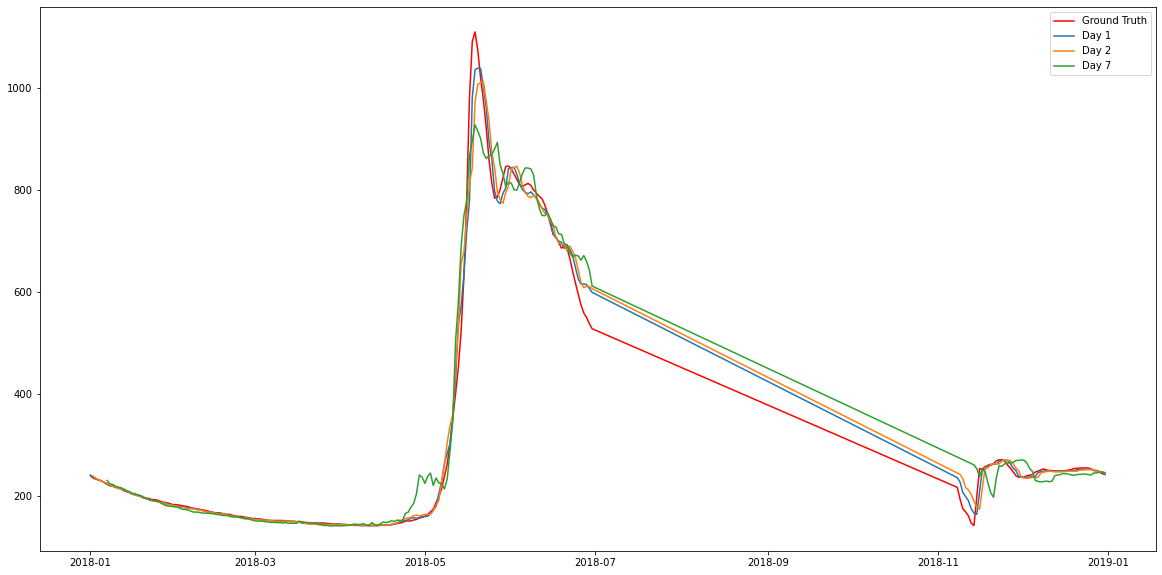

In [12]:
def rmse(x, y): return np.sqrt(mean_squared_error(x, y))

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    res = pd.DataFrame()
    res['date'] = seq_test.date[:-1] + pd.Timedelta(1+i, unit='D')
    res['pred'] = seq_test.data[:-1, i]
    df_res = res.merge(test[['date', 'stage_max']], on=['date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])

    print(f'Day {i+1}: RMSE {metric}: MAE {metric2}')
    if i == 0:
        ax.plot(df_res['date'], df_res['stage_max'], c='r', label='Ground Truth')
    if i in [0, 1, 6]:
        ax.plot(df_res['date'], df_res['pred'], label=f'Day {i+1}')
plt.legend()
plt.show()
    
    

In [13]:
# на текущий момент не хотим считать метрику по 7 наблюдениям перед обрывом в наблюденяих,
# так как там для них мы не знаем истинную целевую переменную (для всех 7 точек), либо переменные.
COND = ((col <= '2018-06-23') | (col > '2018-11-07')).values

# аналогично создаем условие для наших предсказаний.
# так как оно сделало предсказание на периоды, когда мы не знаем целевую переменную.
col_time_pred = pd.Series(seq_test.date[:-1] + pd.Timedelta(1, unit='D'))
COND2 = ((col_time_pred <= '2018-06-23') | (col_time_pred > '2018-11-07')).values

## Сравнение с бейзлайнами:

### Медиана по дню недели.

In [14]:
train_c = train[['date', 'stage_max']].copy()
test_c = test[['date', 'stage_max']].iloc[7:].copy()
for df in [train_c, test_c]:
    df['dayofyear'] = pd.to_datetime(df.date).dt.dayofyear
    
statistic = train_c.groupby('dayofyear')['stage_max'].apply(np.median)
pred_naive = test_c.dayofyear.map(statistic)
print("Naive, MAE: {}".format(np.round(mean_absolute_error(test_c[roles['target']].values[COND], pred_naive[COND]), 4)))

Naive, MAE: 45.5461


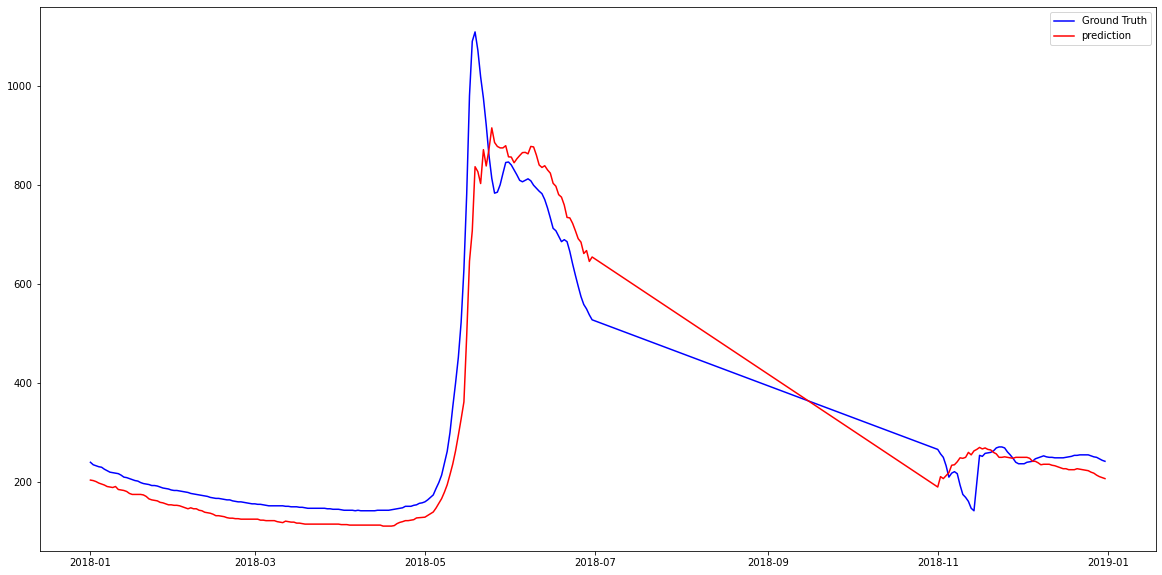

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(col, test.stage_max.values[7:], c='b', label='Ground Truth')
ax.plot(col, pred_naive.values, c='r', label='prediction')

plt.legend()
plt.show()

### Значение за предыдущий год.

In [16]:
train_c = train[['date', 'stage_max']].copy()
train_c = train_c[train_c.date >= '2017-01-01']
test_c = test[['date', 'stage_max']].iloc[7:].copy()
for df in [train_c, test_c]:
    df['dayofyear'] = pd.to_datetime(df.date).dt.dayofyear
    
statistic = train_c.groupby('dayofyear')['stage_max'].apply(np.median)
pred_naive = test_c.dayofyear.map(statistic)
print("Naive, MAE: {}".format(np.round(mean_absolute_error(test_c[roles['target']].values[COND], pred_naive[COND]), 4)))

Naive, MAE: 40.557


### Эвристика с ТОП2 private lb хакатона.

In [17]:
train_c = train[['date', 'stage_max']].copy()
test_c = test[['date', 'stage_max']].iloc[7:].copy()
for df in [train_c, test_c]:
    df['year'] = pd.to_datetime(df.date).dt.year
    df['dayofyear'] = pd.to_datetime(df.date).dt.dayofyear


df_avg = []
for pair, group in train_c.groupby(['year']):
    avg_at_year = pd.concat([group['stage_max'].shift(i) for i in range(-10, 10)], axis=1).mean(axis=1)
    avg_at_year = pd.DataFrame(avg_at_year, columns=['stage_max_avg'])
    avg_at_year['year'] = pair
    avg_at_year['date'] = group['date']
    df_avg.append(avg_at_year)
df_avg = pd.concat(df_avg)
df_avg['dayofyear'] =  pd.to_datetime(df_avg['date']).dt.dayofyear
statistic2 = df_avg.groupby(['dayofyear'])['stage_max_avg'].median()

pred_naive2 = test_c.dayofyear.map(statistic2)
print("Naive 2, MAE: {}".format(np.round(mean_absolute_error(test_c[roles['target']].values[COND], pred_naive2[COND]), 4)))


Naive 2, MAE: 38.0488


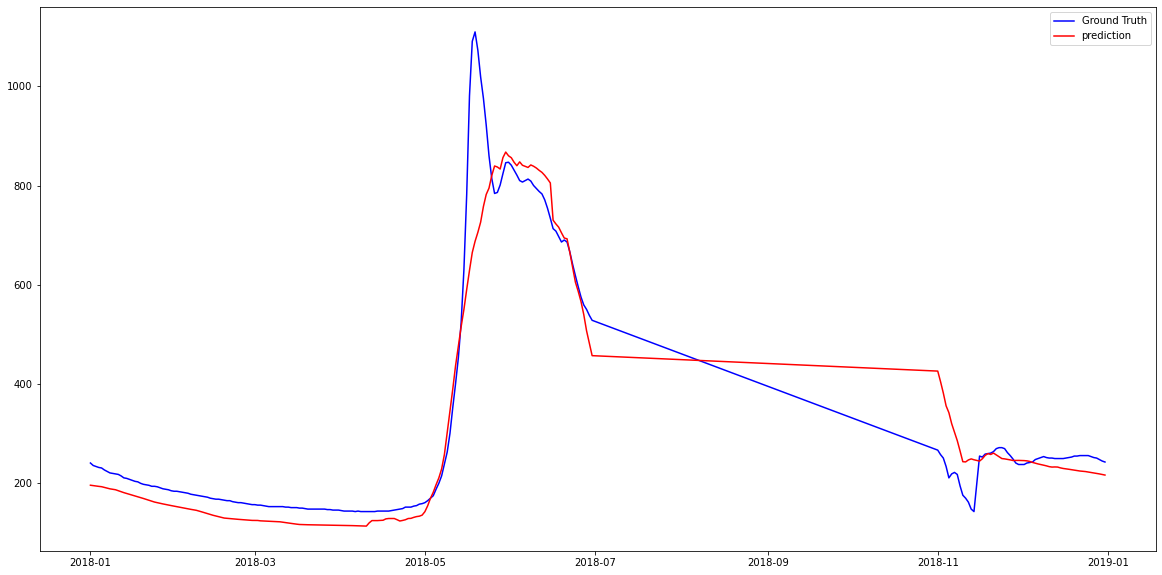

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(col, test.stage_max.values[7:], c='b', label='Ground Truth')
ax.plot(col, pred_naive2.values, c='r', label='prediction')

plt.legend()
plt.show()

### Медиана в скользящем окне размера 7.

Day 1: RMSE 81.14389635020996: MAE 30.58723404255319
Day 2: RMSE 96.77377273894386: MAE 37.34334763948498
Day 3: RMSE 110.71595027375976: MAE 43.53679653679654
Day 4: RMSE 123.15620074384964: MAE 49.03056768558952
Day 5: RMSE 134.23577127855637: MAE 53.82378854625551
Day 6: RMSE 144.11042062714733: MAE 58.14222222222222
Day 7: RMSE 153.0027990013325: MAE 62.152466367713004


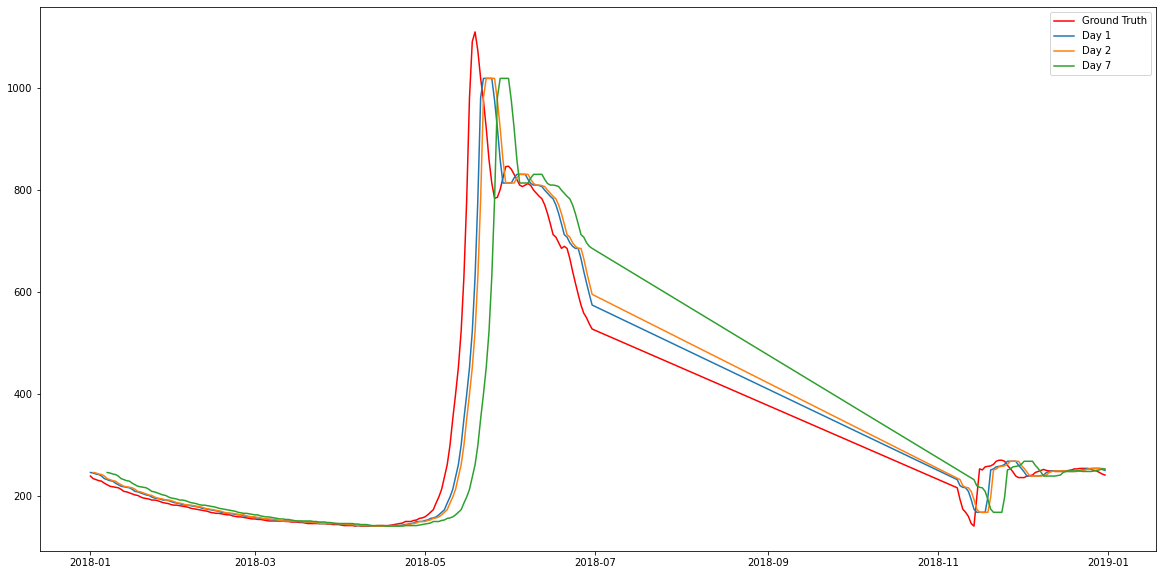

In [19]:
train_c = train[['date', 'stage_max']].copy()
test_c = test[['date', 'stage_max']].copy()

pred_rolling = test_c.rolling(7).median().dropna().values.flatten()[:-1] 

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    res = pd.DataFrame()
    res['date'] = seq_test.date[:-1] + pd.Timedelta(1+i, unit='D')
    _df = pd.DataFrame() 
    _df['date'] = test_c.iloc[7:]['date'].values[i:]
    _df['pred'] = pred_rolling[:-i] if i!=0 else pred_rolling
    
    #res['pred'] = seq_test.data[:-1, i]
    df_res = res.merge(test[['date', 'stage_max']], on=['date'], how='left').dropna(axis=0)
    df_res = df_res.merge(_df[['date', 'pred']], on=['date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])

    print(f'Day {i+1}: RMSE {metric}: MAE {metric2}')
    if i == 0:
        ax.plot(df_res['date'], df_res['stage_max'], c='r', label='Ground Truth')
    if i in [0, 1, 6]:
        ax.plot(df_res['date'], df_res['pred'], label=f'Day {i+1}')
plt.legend()
plt.show()
    
    

### Предсказание последним известным значением.

Day 1: RMSE 23.79701393747597: MAE 8.86808510638298
Day 2: RMSE 46.044250035953354: MAE 17.386266094420602
Day 3: RMSE 66.18323639125529: MAE 25.450216450216452
Day 4: RMSE 84.18232448357858: MAE 32.698689956331876
Day 5: RMSE 100.19215019327824: MAE 39.40088105726872
Day 6: RMSE 114.40034964981533: MAE 45.60888888888889
Day 7: RMSE 126.92824850701398: MAE 51.06726457399103


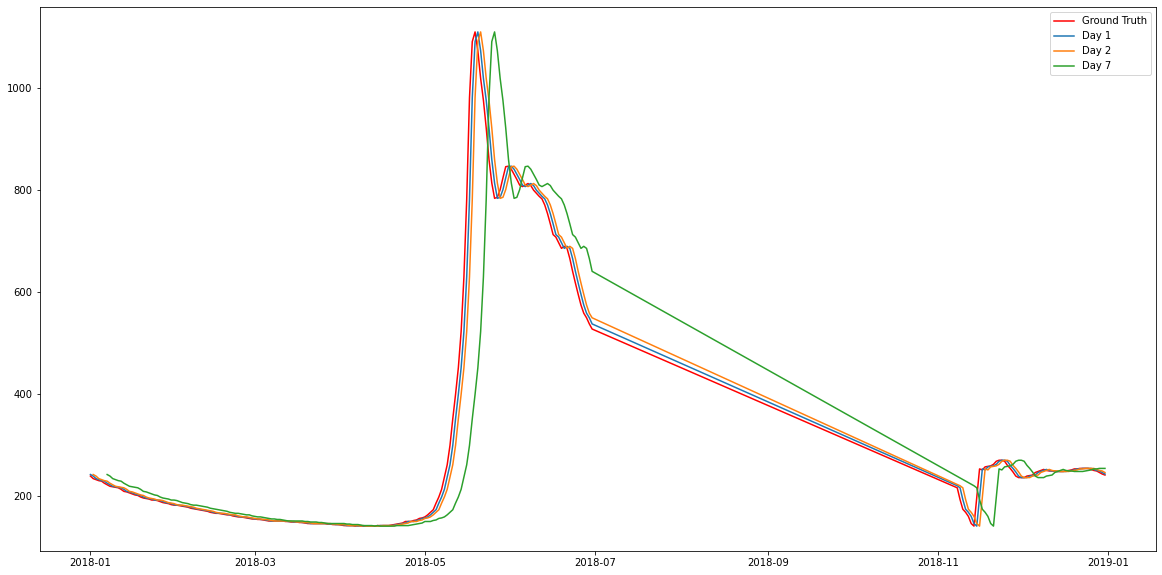

In [20]:
def get_last(x):
    return list(x)[-1]

train_c = train[['date', 'stage_max']].copy()
test_c = test[['date', 'stage_max']].copy()
pred_rolling_last = test_c.rolling(7).apply(get_last).dropna().values.flatten()[:-1]

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    res = pd.DataFrame()
    res['date'] = seq_test.date[:-1] + pd.Timedelta(1+i, unit='D')

    _df = pd.DataFrame() 
    _df['date'] = test_c.iloc[7:]['date'].values[i:]
    _df['pred'] = pred_rolling_last[:-i] if i!=0 else pred_rolling_last
    
    df_res = res.merge(test[['date', 'stage_max']], on=['date'], how='left').dropna(axis=0)
    df_res = df_res.merge(_df[['date', 'pred']], on=['date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])

    print(f'Day {i+1}: RMSE {metric}: MAE {metric2}')
    if i == 0:
        ax.plot(df_res['date'], df_res['stage_max'], c='r', label='Ground Truth')
    if i in [0, 1, 6]:
        ax.plot(df_res['date'], df_res['pred'], label=f'Day {i+1}')
plt.legend()
plt.show()
    
    

#### Еще раз метрики модели

Day 1: RMSE 22.548188636458473: MAE 9.27916740255153
Day 2: RMSE 31.294454963237932: MAE 13.484963216495105
Day 3: RMSE 36.96926503063696: MAE 16.659810119893127
Day 4: RMSE 39.971662206345826: MAE 19.30329661806598
Day 5: RMSE 40.56205976339451: MAE 20.320639723723154
Day 6: RMSE 41.10444161245755: MAE 21.33828118218316
Day 7: RMSE 41.58286694000721: MAE 22.14264812383951


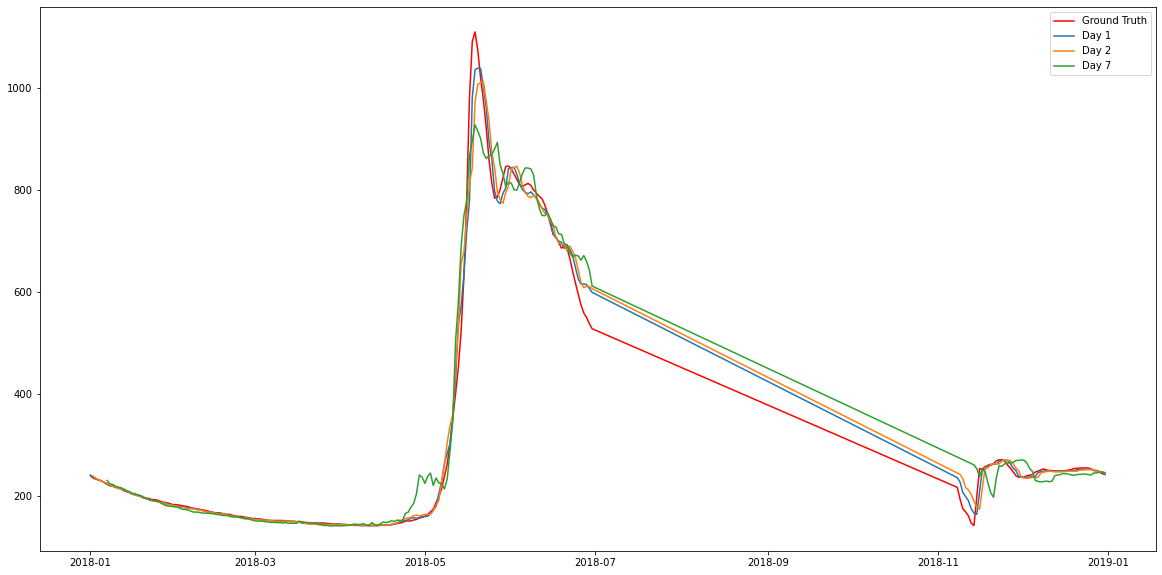

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    res = pd.DataFrame()
    res['date'] = seq_test.date[:-1] + pd.Timedelta(1+i, unit='D')
    res['pred'] = seq_test.data[:-1, i]

    df_res = res.merge(test[['date', 'stage_max']], on=['date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])

    print(f'Day {i+1}: RMSE {metric}: MAE {metric2}')
    if i == 0:
        ax.plot(df_res['date'], df_res['stage_max'], c='r', label='Ground Truth')
    if i in [0, 1, 6]:
        ax.plot(df_res['date'], df_res['pred'], label=f'Day {i+1}')
plt.legend()
plt.show()
    
    